In [1]:
from planetHole import planetHole

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import glob

In [3]:
# progress bars
from tqdm import tqdm

In [4]:
fluxes = np.arange(-950,-1300,-50)
fluxes

array([ -950, -1000, -1050, -1100, -1150, -1200, -1250])

In [5]:
# doing zero injection reduction to find rough pos to start flux parameter exploration
ph = planetHole('datum0', 'test_pa'+str(0)+'sep'+str(0), 'output', fluxes[0], 0, 0,
                fwhm=3, ghostpath='ghost.fits', highpass=False,
                klipparams=[6, 3, [50]], usegaussian=True)
ph.run_KLIP()
path = str(ph.get_result(2))
print('grabbing '+path)
with fits.open(path) as img:
    im = img[1].data[2]
    plt.imshow(im[210:230,205:225], origin='lower')
residual = np.sum(im[210:230,205:225])
print('')
print('residual for '+path+' is '+str(residual))
print('')

In [5]:
# do flux parameter exploration
flux_resids = np.zeros(len(fluxes))
for i in tqdm(range(len(fluxes))):
    flux = fluxes[i]
    ph = planetHole('datum0', 'test_flux'+str(flux), 'output', flux, 9, 111,
                    fwhm=3, ghostpath='ghost.fits', highpass=False,
                    klipparams=[6, 3, [50]], usegaussian=True)
    ph.run_KLIP()
    path = str(ph.get_result(2))
    print('grabbing '+path)
    with fits.open(path) as img:
        im = img[1].data[0]
    residual = np.nansum(im[210:230,205:225])
    print('')
    print('residual for '+path+' is '+str(residual))
    print('')
    flux_resids[i] += residual
    

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)


 14%|████████████                                                                        | 1/7 [01:05<06:31, 65.19s/it]

KLIP result is saved to: output\test_flux-950-KLmodes-all.fits
result dir is output\test_flux-950-KLmodes-all.fits
grabbing output\test_flux-950-KLmodes-all.fits

residual for output\test_flux-950-KLmodes-all.fits is -584.6993

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)


 29%|████████████████████████                                                            | 2/7 [02:09<05:24, 64.87s/it]

KLIP result is saved to: output\test_flux-1000-KLmodes-all.fits
result dir is output\test_flux-1000-KLmodes-all.fits
grabbing output\test_flux-1000-KLmodes-all.fits

residual for output\test_flux-1000-KLmodes-all.fits is -503.7409

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)


 43%|████████████████████████████████████                                                | 3/7 [03:14<04:19, 64.86s/it]

KLIP result is saved to: output\test_flux-1050-KLmodes-all.fits
result dir is output\test_flux-1050-KLmodes-all.fits
grabbing output\test_flux-1050-KLmodes-all.fits

residual for output\test_flux-1050-KLmodes-all.fits is -403.53427

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)


 57%|████████████████████████████████████████████████                                    | 4/7 [04:19<03:14, 64.94s/it]

KLIP result is saved to: output\test_flux-1100-KLmodes-all.fits
result dir is output\test_flux-1100-KLmodes-all.fits
grabbing output\test_flux-1100-KLmodes-all.fits

residual for output\test_flux-1100-KLmodes-all.fits is -356.70544

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)


 71%|████████████████████████████████████████████████████████████                        | 5/7 [05:25<02:10, 65.38s/it]

KLIP result is saved to: output\test_flux-1150-KLmodes-all.fits
result dir is output\test_flux-1150-KLmodes-all.fits
grabbing output\test_flux-1150-KLmodes-all.fits

residual for output\test_flux-1150-KLmodes-all.fits is -376.67908

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [06:30<01:05, 65.32s/it]

KLIP result is saved to: output\test_flux-1200-KLmodes-all.fits
result dir is output\test_flux-1200-KLmodes-all.fits
grabbing output\test_flux-1200-KLmodes-all.fits

residual for output\test_flux-1200-KLmodes-all.fits is -417.72922

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:36<00:00, 65.24s/it]

KLIP result is saved to: output\test_flux-1250-KLmodes-all.fits
result dir is output\test_flux-1250-KLmodes-all.fits
grabbing output\test_flux-1250-KLmodes-all.fits

residual for output\test_flux-1250-KLmodes-all.fits is -450.97797



In [8]:
paths = glob.glob('output/test_flux*.fits')
paths = [paths[6]] + paths[0:6]
paths

['output\\test_flux-950-KLmodes-all.fits',
 'output\\test_flux-1000-KLmodes-all.fits',
 'output\\test_flux-1050-KLmodes-all.fits',
 'output\\test_flux-1100-KLmodes-all.fits',
 'output\\test_flux-1150-KLmodes-all.fits',
 'output\\test_flux-1200-KLmodes-all.fits',
 'output\\test_flux-1250-KLmodes-all.fits']

In [9]:
def trim_axs(axs, N):
    """conform the axs list to have correct length"""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

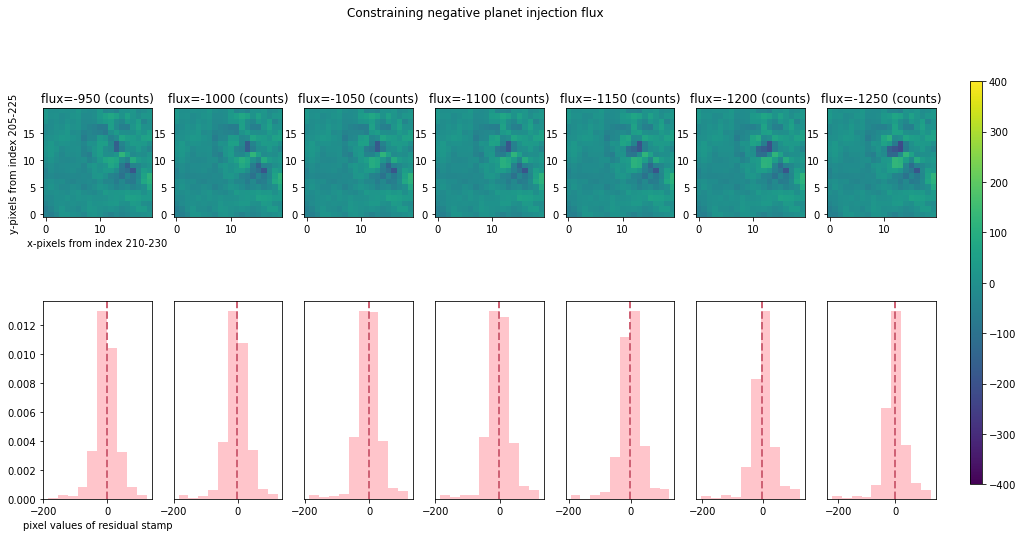

In [15]:
fig1, axs = plt.subplots(2, 7, figsize=(16,8))
axs = trim_axs(axs, 2*len(fluxes))

fig1.suptitle('Constraining negative planet injection flux')
axs[0].set_xlabel('x-pixels from index 210-230')
axs[0].set_ylabel('y-pixels from index 205-225')

axs[7].set_xlabel('pixel values of residual stamp')

fluxes2 = fluxes.tolist()

for ax, i in zip(axs, range(len(axs))):
    if i < len(paths):
        path = paths[i]
        flux = fluxes2[i]
        ax.set_title('flux=%s (counts)' % str(flux))
        with fits.open(path) as img:
            im = img[1].data[0]
            stamp = im[210:230,205:225]
            axis = ax.imshow(stamp, origin='lower', vmin=-400, vmax=400)
    else:
        j = i-(int(len(axs)/2))
        path = paths[j]
        flux = fluxes2[j]
        with fits.open(path) as img:
            im = img[1].data[0]
            stamp = im[210:230,205:225]
            vals = stamp.flatten()
            ax.hist(vals, density=True, color='xkcd:light rose')
            ax.axvline(x=np.nanmedian(vals), color='xkcd:rose', linestyle='dashed', linewidth=2)
            
        if i > len(paths):
            ax.get_yaxis().set_visible(False)

cbar_ax = fig1.add_axes([0.93, 0.15, 0.01, 0.7])
fig1.colorbar(axis, cax=cbar_ax)
plt.savefig('negativeplanet_flux_fine.png', dpi=200)

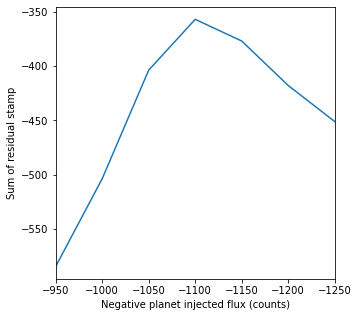

In [14]:
plt.figure(figsize=(5,5))
plt.plot(fluxes, flux_resids)
plt.xlabel('Negative planet injected flux (counts)')
plt.xlim(-950,-1250)
plt.ylabel('Sum of residual stamp')
plt.savefig('sumvsflux.png', dpi=200)

In [22]:
# param_space = np.zeros((len(range(109,111)), len(range(9,11))))
# for pa in tqdm(range(109,111)):
#     for sep in range(9,11):
#         ph = planetHole('datum0', 'test_pa'+str(pa)+'sep'+str(sep), 'output', -1000, sep, pa,
#                  fwhm=3, ghostpath='ghost.fits', highpass=False,
#                  klipparams=[6, 3, [1, 5, 50]], usegaussian=True)
#         ph.run_KLIP()
#         path = str(ph.get_result(2))
#         print('grabbing '+path)
#         with fits.open(path) as img:
#             im = img[1].data[2]
#         residual = np.nansum(im[210:230,205:225])
#         print('')
#         print('residual for '+path+' is '+str(residual))
#         print('')
#         param_space[pa-109,sep-9] += residual

# print(param_space)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(3, 153, 1, 451, 451)
KLIP result is saved to: output\test_pa109sep9-KLmodes-all.fits
result dir is output\test_pa109sep9-KLmodes-all.fits
grabbing output\test_pa109sep9-KLmodes-all.fits

residual for output\test_pa109sep9-KLmodes-all.fits is -748.41315

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength c

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:39<02:39, 159.55s/it]

KLIP result is saved to: output\test_pa109sep10-KLmodes-all.fits
result dir is output\test_pa109sep10-KLmodes-all.fits
grabbing output\test_pa109sep10-KLmodes-all.fits

residual for output\test_pa109sep10-KLmodes-all.fits is -949.6642

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(3, 153, 1, 451, 451)
KLIP result is saved to: output\test_pa110sep9-KLmodes-all.fits
result dir is output\test_pa110sep9-KLmodes-all.fits
grabbing output\test_pa110sep9-KLmodes-all.fits

residual for output\test_pa110sep9-KLmodes-all.fits is -614.4364

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has 

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [05:15<00:00, 157.60s/it]

KLIP result is saved to: output\test_pa110sep10-KLmodes-all.fits
result dir is output\test_pa110sep10-KLmodes-all.fits
grabbing output\test_pa110sep10-KLmodes-all.fits

residual for output\test_pa110sep10-KLmodes-all.fits is -871.4548

[[-748.41314697 -949.66418457]
 [-614.43640137 -871.45477295]]


In [5]:
paths = glob.glob('output/*pa1*.fits')
paths

[]

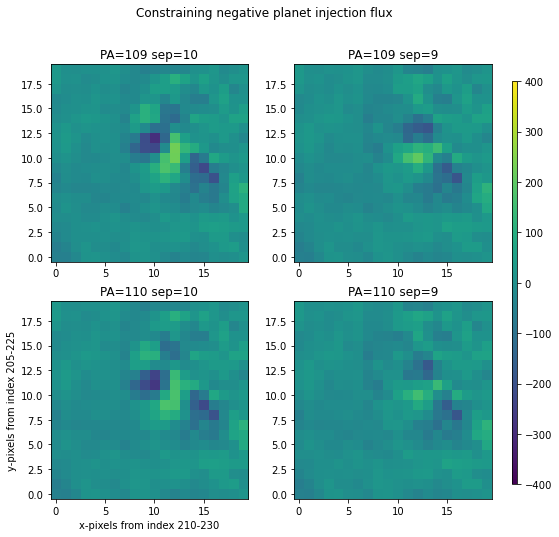

In [35]:
# fig1, axs = plt.subplots(2, 2, figsize=(8,8))
# axs = trim_axs(axs, len(paths))

# fig1.suptitle('Constraining negative planet injection flux')
# axs[2].set_xlabel('x-pixels from index 210-230')
# axs[2].set_ylabel('y-pixels from index 205-225')

# pas = [109,109,110,110]
# seps = [10,9,10,9]

# for ax, i in zip(axs, range(len(paths))):
#     path = paths[i]
#     pa = pas[i]
#     sep = seps[i]
#     ax.set_title('PA='+str(pa)+' sep='+str(sep))
#     with fits.open(path) as img:
#         im = img[1].data[2]
#         stamp = im[210:230,205:225]
#     axis = ax.imshow(stamp, origin='lower', vmin=-400, vmax=400)

# cbar_ax = fig1.add_axes([0.93, 0.15, 0.01, 0.7])
# fig1.colorbar(axis, cax=cbar_ax)

In [5]:
pas = range(106,119,3)
seps = range(3,17,2)
param_space = np.zeros((len(pas), len(seps)))

for i in tqdm(range(len(pas))):
    pa = pas[i]
    for j in tqdm(range(len(seps))):
        sep = seps[j]
        ph = planetHole('datum0', 'test_pa'+str(pa)+'sep'+str(sep), 'output', -1000, sep, pa,
                        fwhm=3, ghostpath='ghost.fits', highpass=False,
                        klipparams=[6, 3, [50]], usegaussian=True)
        ph.run_KLIP()
        path = str(ph.get_result(0))
        print('grabbing '+path)
        with fits.open(path) as img:
            im = img[1].data[0]
        residual = np.nansum(im[210:230,205:225])
        print('')
        print('residual for '+path+' is '+str(residual))
        print('')
        param_space[i,j] += residual

print(param_space)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 14%|████████████                                                                        | 1/7 [01:06<06:39, 66.50s/it]

KLIP result is saved to: output\test_pa106sep3-KLmodes-all.fits
result dir is output\test_pa106sep3-KLmodes-all.fits
grabbing output\test_pa106sep3-KLmodes-all.fits

residual for output\test_pa106sep3-KLmodes-all.fits is -1174.7764

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 29%|████████████████████████                                                            | 2/7 [02:13<05:33, 66.62s/it]

KLIP result is saved to: output\test_pa106sep5-KLmodes-all.fits
result dir is output\test_pa106sep5-KLmodes-all.fits
grabbing output\test_pa106sep5-KLmodes-all.fits

residual for output\test_pa106sep5-KLmodes-all.fits is -1054.2733

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 43%|████████████████████████████████████                                                | 3/7 [03:21<04:27, 66.92s/it]

KLIP result is saved to: output\test_pa106sep7-KLmodes-all.fits
result dir is output\test_pa106sep7-KLmodes-all.fits
grabbing output\test_pa106sep7-KLmodes-all.fits

residual for output\test_pa106sep7-KLmodes-all.fits is -1213.8539

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 57%|████████████████████████████████████████████████                                    | 4/7 [04:29<03:21, 67.33s/it]

KLIP result is saved to: output\test_pa106sep9-KLmodes-all.fits
result dir is output\test_pa106sep9-KLmodes-all.fits
grabbing output\test_pa106sep9-KLmodes-all.fits

residual for output\test_pa106sep9-KLmodes-all.fits is -1140.3615

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 71%|████████████████████████████████████████████████████████████                        | 5/7 [05:36<02:14, 67.33s/it]

KLIP result is saved to: output\test_pa106sep11-KLmodes-all.fits
result dir is output\test_pa106sep11-KLmodes-all.fits
grabbing output\test_pa106sep11-KLmodes-all.fits

residual for output\test_pa106sep11-KLmodes-all.fits is -1264.7008

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [06:43<01:07, 67.25s/it]

KLIP result is saved to: output\test_pa106sep13-KLmodes-all.fits
result dir is output\test_pa106sep13-KLmodes-all.fits
grabbing output\test_pa106sep13-KLmodes-all.fits

residual for output\test_pa106sep13-KLmodes-all.fits is -1337.8062

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa106sep15-KLmodes-all.fits
result dir is output\test_pa106sep15-KLmodes-all.fits
grabbing output\test_pa106sep15-KLmodes-all.fits

residual for output\test_pa106sep15-KLmodes-all.fits is -1430.8887

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 14%|████████████                                                                        | 1/7 [01:07<06:43, 67.25s/it]

KLIP result is saved to: output\test_pa109sep3-KLmodes-all.fits
result dir is output\test_pa109sep3-KLmodes-all.fits
grabbing output\test_pa109sep3-KLmodes-all.fits

residual for output\test_pa109sep3-KLmodes-all.fits is -1159.7137

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 29%|████████████████████████                                                            | 2/7 [02:15<05:37, 67.46s/it]

KLIP result is saved to: output\test_pa109sep5-KLmodes-all.fits
result dir is output\test_pa109sep5-KLmodes-all.fits
grabbing output\test_pa109sep5-KLmodes-all.fits

residual for output\test_pa109sep5-KLmodes-all.fits is -1058.5125

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 43%|████████████████████████████████████                                                | 3/7 [03:22<04:29, 67.46s/it]

KLIP result is saved to: output\test_pa109sep7-KLmodes-all.fits
result dir is output\test_pa109sep7-KLmodes-all.fits
grabbing output\test_pa109sep7-KLmodes-all.fits

residual for output\test_pa109sep7-KLmodes-all.fits is -1269.4575

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 57%|████████████████████████████████████████████████                                    | 4/7 [04:30<03:22, 67.45s/it]

KLIP result is saved to: output\test_pa109sep9-KLmodes-all.fits
result dir is output\test_pa109sep9-KLmodes-all.fits
grabbing output\test_pa109sep9-KLmodes-all.fits

residual for output\test_pa109sep9-KLmodes-all.fits is -748.41315

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 71%|████████████████████████████████████████████████████████████                        | 5/7 [05:37<02:14, 67.40s/it]

KLIP result is saved to: output\test_pa109sep11-KLmodes-all.fits
result dir is output\test_pa109sep11-KLmodes-all.fits
grabbing output\test_pa109sep11-KLmodes-all.fits

residual for output\test_pa109sep11-KLmodes-all.fits is -974.8541

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [06:44<01:07, 67.34s/it]

KLIP result is saved to: output\test_pa109sep13-KLmodes-all.fits
result dir is output\test_pa109sep13-KLmodes-all.fits
grabbing output\test_pa109sep13-KLmodes-all.fits

residual for output\test_pa109sep13-KLmodes-all.fits is -1198.5508

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa109sep15-KLmodes-all.fits
result dir is output\test_pa109sep15-KLmodes-all.fits
grabbing output\test_pa109sep15-KLmodes-all.fits

residual for output\test_pa109sep15-KLmodes-all.fits is -1399.0603

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 14%|████████████                                                                        | 1/7 [01:04<06:28, 64.74s/it]

KLIP result is saved to: output\test_pa112sep3-KLmodes-all.fits
result dir is output\test_pa112sep3-KLmodes-all.fits
grabbing output\test_pa112sep3-KLmodes-all.fits

residual for output\test_pa112sep3-KLmodes-all.fits is -1138.6766

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 29%|████████████████████████                                                            | 2/7 [02:09<05:23, 64.71s/it]

KLIP result is saved to: output\test_pa112sep5-KLmodes-all.fits
result dir is output\test_pa112sep5-KLmodes-all.fits
grabbing output\test_pa112sep5-KLmodes-all.fits

residual for output\test_pa112sep5-KLmodes-all.fits is -1082.2725

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 43%|████████████████████████████████████                                                | 3/7 [03:13<04:18, 64.68s/it]

KLIP result is saved to: output\test_pa112sep7-KLmodes-all.fits
result dir is output\test_pa112sep7-KLmodes-all.fits
grabbing output\test_pa112sep7-KLmodes-all.fits

residual for output\test_pa112sep7-KLmodes-all.fits is -1133.6443

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 57%|████████████████████████████████████████████████                                    | 4/7 [04:18<03:14, 64.73s/it]

KLIP result is saved to: output\test_pa112sep9-KLmodes-all.fits
result dir is output\test_pa112sep9-KLmodes-all.fits
grabbing output\test_pa112sep9-KLmodes-all.fits

residual for output\test_pa112sep9-KLmodes-all.fits is -412.77878

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 71%|████████████████████████████████████████████████████████████                        | 5/7 [05:24<02:09, 64.89s/it]

KLIP result is saved to: output\test_pa112sep11-KLmodes-all.fits
result dir is output\test_pa112sep11-KLmodes-all.fits
grabbing output\test_pa112sep11-KLmodes-all.fits

residual for output\test_pa112sep11-KLmodes-all.fits is -716.4333

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [06:28<01:04, 64.83s/it]

KLIP result is saved to: output\test_pa112sep13-KLmodes-all.fits
result dir is output\test_pa112sep13-KLmodes-all.fits
grabbing output\test_pa112sep13-KLmodes-all.fits

residual for output\test_pa112sep13-KLmodes-all.fits is -1054.598

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa112sep15-KLmodes-all.fits
result dir is output\test_pa112sep15-KLmodes-all.fits
grabbing output\test_pa112sep15-KLmodes-all.fits

residual for output\test_pa112sep15-KLmodes-all.fits is -1519.5176

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 14%|████████████                                                                        | 1/7 [01:04<06:27, 64.63s/it]

KLIP result is saved to: output\test_pa115sep3-KLmodes-all.fits
result dir is output\test_pa115sep3-KLmodes-all.fits
grabbing output\test_pa115sep3-KLmodes-all.fits

residual for output\test_pa115sep3-KLmodes-all.fits is -1093.9092

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 29%|████████████████████████                                                            | 2/7 [02:09<05:24, 64.82s/it]

KLIP result is saved to: output\test_pa115sep5-KLmodes-all.fits
result dir is output\test_pa115sep5-KLmodes-all.fits
grabbing output\test_pa115sep5-KLmodes-all.fits

residual for output\test_pa115sep5-KLmodes-all.fits is -1144.5371

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 43%|████████████████████████████████████                                                | 3/7 [03:14<04:19, 64.79s/it]

KLIP result is saved to: output\test_pa115sep7-KLmodes-all.fits
result dir is output\test_pa115sep7-KLmodes-all.fits
grabbing output\test_pa115sep7-KLmodes-all.fits

residual for output\test_pa115sep7-KLmodes-all.fits is -1090.3397

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 57%|████████████████████████████████████████████████                                    | 4/7 [04:19<03:14, 64.88s/it]

KLIP result is saved to: output\test_pa115sep9-KLmodes-all.fits
result dir is output\test_pa115sep9-KLmodes-all.fits
grabbing output\test_pa115sep9-KLmodes-all.fits

residual for output\test_pa115sep9-KLmodes-all.fits is -274.1828

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 71%|████████████████████████████████████████████████████████████                        | 5/7 [05:23<02:09, 64.71s/it]

KLIP result is saved to: output\test_pa115sep11-KLmodes-all.fits
result dir is output\test_pa115sep11-KLmodes-all.fits
grabbing output\test_pa115sep11-KLmodes-all.fits

residual for output\test_pa115sep11-KLmodes-all.fits is -646.7567

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [06:28<01:04, 64.78s/it]

KLIP result is saved to: output\test_pa115sep13-KLmodes-all.fits
result dir is output\test_pa115sep13-KLmodes-all.fits
grabbing output\test_pa115sep13-KLmodes-all.fits

residual for output\test_pa115sep13-KLmodes-all.fits is -951.77454

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa115sep15-KLmodes-all.fits
result dir is output\test_pa115sep15-KLmodes-all.fits
grabbing output\test_pa115sep15-KLmodes-all.fits

residual for output\test_pa115sep15-KLmodes-all.fits is -1662.4565

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 14%|████████████                                                                        | 1/7 [01:05<06:31, 65.27s/it]

KLIP result is saved to: output\test_pa118sep3-KLmodes-all.fits
result dir is output\test_pa118sep3-KLmodes-all.fits
grabbing output\test_pa118sep3-KLmodes-all.fits

residual for output\test_pa118sep3-KLmodes-all.fits is -1120.5308

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 29%|████████████████████████                                                            | 2/7 [02:09<05:24, 64.95s/it]

KLIP result is saved to: output\test_pa118sep5-KLmodes-all.fits
result dir is output\test_pa118sep5-KLmodes-all.fits
grabbing output\test_pa118sep5-KLmodes-all.fits

residual for output\test_pa118sep5-KLmodes-all.fits is -1240.3627

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 43%|████████████████████████████████████                                                | 3/7 [03:14<04:19, 64.86s/it]

KLIP result is saved to: output\test_pa118sep7-KLmodes-all.fits
result dir is output\test_pa118sep7-KLmodes-all.fits
grabbing output\test_pa118sep7-KLmodes-all.fits

residual for output\test_pa118sep7-KLmodes-all.fits is -1086.0251

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 57%|████████████████████████████████████████████▌                                 | 4/7 [1:45:25<1:34:14, 1884.93s/it]

KLIP result is saved to: output\test_pa118sep9-KLmodes-all.fits
result dir is output\test_pa118sep9-KLmodes-all.fits
grabbing output\test_pa118sep9-KLmodes-all.fits

residual for output\test_pa118sep9-KLmodes-all.fits is -336.85007

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 71%|█████████████████████████████████████████████████████████▏                      | 5/7 [1:46:36<44:41, 1340.50s/it]

KLIP result is saved to: output\test_pa118sep11-KLmodes-all.fits
result dir is output\test_pa118sep11-KLmodes-all.fits
grabbing output\test_pa118sep11-KLmodes-all.fits

residual for output\test_pa118sep11-KLmodes-all.fits is -697.2462

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 86%|█████████████████████████████████████████████████████████████████████▍           | 6/7 [1:47:42<15:58, 958.28s/it]

KLIP result is saved to: output\test_pa118sep13-KLmodes-all.fits
result dir is output\test_pa118sep13-KLmodes-all.fits
grabbing output\test_pa118sep13-KLmodes-all.fits

residual for output\test_pa118sep13-KLmodes-all.fits is -1053.2861

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:19:36<00:00, 1675.38s/it]

KLIP result is saved to: output\test_pa118sep15-KLmodes-all.fits
result dir is output\test_pa118sep15-KLmodes-all.fits
grabbing output\test_pa118sep15-KLmodes-all.fits

residual for output\test_pa118sep15-KLmodes-all.fits is -1727.4829

[[-1174.77636719 -1054.27331543 -1213.85388184 -1140.3614502
  -1264.70080566 -1337.80615234 -1430.88867188]
 [-1159.71374512 -1058.51245117 -1269.45751953  -748.41314697
   -974.85412598 -1198.55078125 -1399.06030273]
 [-1138.67663574 -1082.27246094 -1133.64428711  -412.77877808
   -716.43328857 -1054.59802246 -1519.51757812]
 [-1093.90917969 -1144.53710938 -1090.33972168  -274.18280029
   -646.75671387  -951.77453613 -1662.45654297]
 [-1120.53076172 -1240.3626709  -1086.02514648  -336.85006714
   -697.24621582 -1053.28613281 -1727.48291016]]


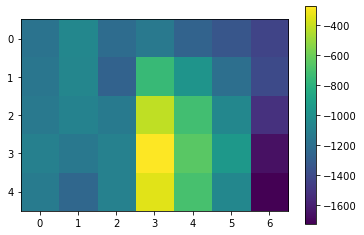

In [6]:
plt.imshow(param_space)
plt.colorbar()

In [7]:
paths = glob.glob('output/*pa1*.fits')

['output\\test_pa106sep11-KLmodes-all.fits',
 'output\\test_pa106sep13-KLmodes-all.fits',
 'output\\test_pa106sep15-KLmodes-all.fits',
 'output\\test_pa106sep3-KLmodes-all.fits',
 'output\\test_pa106sep5-KLmodes-all.fits',
 'output\\test_pa106sep7-KLmodes-all.fits',
 'output\\test_pa106sep9-KLmodes-all.fits',
 'output\\test_pa109sep11-KLmodes-all.fits',
 'output\\test_pa109sep13-KLmodes-all.fits',
 'output\\test_pa109sep15-KLmodes-all.fits',
 'output\\test_pa109sep3-KLmodes-all.fits',
 'output\\test_pa109sep5-KLmodes-all.fits',
 'output\\test_pa109sep7-KLmodes-all.fits',
 'output\\test_pa109sep9-KLmodes-all.fits',
 'output\\test_pa112sep11-KLmodes-all.fits',
 'output\\test_pa112sep13-KLmodes-all.fits',
 'output\\test_pa112sep15-KLmodes-all.fits',
 'output\\test_pa112sep3-KLmodes-all.fits',
 'output\\test_pa112sep5-KLmodes-all.fits',
 'output\\test_pa112sep7-KLmodes-all.fits',
 'output\\test_pa112sep9-KLmodes-all.fits',
 'output\\test_pa115sep11-KLmodes-all.fits',
 'output\\test_pa115se

In [16]:
sortedpaths = paths[3:7] + paths[0:3] + paths[10:13] + paths[6:10] + paths[17:20] + paths[13:17] + paths[24:27] + paths[20:24] + paths[31:35] + paths[27:31]

In [18]:
sortedpaths

['output\\test_pa106sep3-KLmodes-all.fits',
 'output\\test_pa106sep5-KLmodes-all.fits',
 'output\\test_pa106sep7-KLmodes-all.fits',
 'output\\test_pa106sep9-KLmodes-all.fits',
 'output\\test_pa106sep11-KLmodes-all.fits',
 'output\\test_pa106sep13-KLmodes-all.fits',
 'output\\test_pa106sep15-KLmodes-all.fits',
 'output\\test_pa109sep3-KLmodes-all.fits',
 'output\\test_pa109sep5-KLmodes-all.fits',
 'output\\test_pa109sep7-KLmodes-all.fits',
 'output\\test_pa106sep9-KLmodes-all.fits',
 'output\\test_pa109sep11-KLmodes-all.fits',
 'output\\test_pa109sep13-KLmodes-all.fits',
 'output\\test_pa109sep15-KLmodes-all.fits',
 'output\\test_pa112sep3-KLmodes-all.fits',
 'output\\test_pa112sep5-KLmodes-all.fits',
 'output\\test_pa112sep7-KLmodes-all.fits',
 'output\\test_pa109sep9-KLmodes-all.fits',
 'output\\test_pa112sep11-KLmodes-all.fits',
 'output\\test_pa112sep13-KLmodes-all.fits',
 'output\\test_pa112sep15-KLmodes-all.fits',
 'output\\test_pa115sep3-KLmodes-all.fits',
 'output\\test_pa115sep

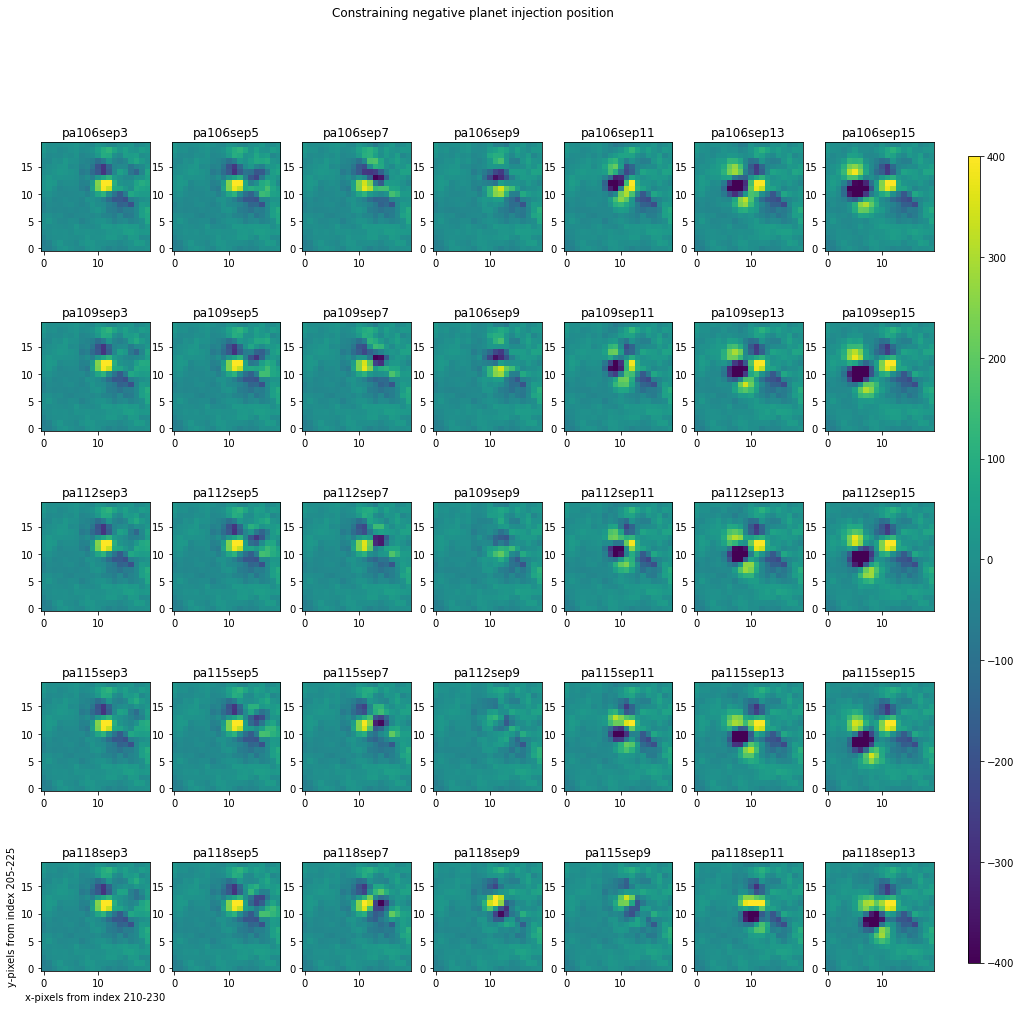

In [17]:
fig1, axs = plt.subplots(5, 7, figsize=(16,16))
axs = trim_axs(axs, len(sortedpaths))

fig1.suptitle('Constraining negative planet injection position')
axs[28].set_xlabel('x-pixels from index 210-230')
axs[28].set_ylabel('y-pixels from index 205-225')

for ax, i in zip(axs, range(len(sortedpaths))):
    path = sortedpaths[i]
    pref, suf = path.split('_')
    params, kl, suff = suf.split('-')
    ax.set_title(params)
    with fits.open(path) as img:
        im = img[1].data[0]
        stamp = im[210:230,205:225]
    axis = ax.imshow(stamp, origin='lower', vmin=-400, vmax=400)

cbar_ax = fig1.add_axes([0.93, 0.15, 0.01, 0.7])
fig1.colorbar(axis, cax=cbar_ax)
plt.savefig('negplanet_position_iteration')

In [24]:
import pickle
filehandler = open('neginj_pos_paramspace', 'wb') 
pickle.dump(param_space, filehandler)